In this exercise we will extend the previous network to a convolutional architecture with max-pooling. To warm up, first answer the following questions, assuming that we have an input image of size (28,28):
* What are the output dimensions when filtering this image using a convolution in "valid" mode with a filter size of (5,5)?

Answer: (24,24)
* When this output is filtered using max-pooling with a filter size of (2,2), what is the dimension of the output?

Answer:(12,12)
* What would be the output when convolving the (28,28) pixel image with a filter of size (5,5) in "full" and "same" modes?

Answer: (32,32) and (28,28)

In the following we will build a Convolutional Neural Network with these building blocks and Theano. Note that the training can take rather long without GPU support, if necessary train on a small dataset for some preliminary tests and later switch to a larger training set for final results. The theano implementation of this exercise is not mandatory and not relevant for your final exams -- understanding convolutions and max-pooling, however, is relevant.

Import the dataset, do not flatten the images. You should however flatten the labels. Reshape the images to get a tensor of shape ${\tt (batchsize,1,28,28)}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, struct
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros

mnist_path="/path/to/mnist"

def load_mnist(dataset="training", digits=np.arange(10), path="."):
    """
    Loads MNIST files into 3D numpy arrays

    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

In [2]:
import theano
#Load the images for training and testing
images, label = load_mnist(dataset="training" , digits=np.arange(10), path=mnist_path)
test_images, test_label = load_mnist(dataset="testing" , digits=np.arange(10), path=mnist_path)
#Flatten the images to get a vectorial representation
images = images.astype(theano.config.floatX).reshape((images.shape[0],1,images.shape[1],images.shape[2]))
test_images = test_images.astype(theano.config.floatX).reshape((test_images.shape[0],1,test_images.shape[1],test_images.shape[2]))
#get the maximum for normalization and normalize to values in range [0,1]
maxval = np.max(images)
images = (images * (1.0/maxval)).astype(theano.config.floatX)
test_images = (test_images * (1.0/maxval))
#flatten the labels to get a vectorial representation
label = label.flatten()
test_label = test_label.flatten()
print test_images.shape
print images.shape
print label.shape
print test_label.shape

(10000, 1, 28, 28)
(60000, 1, 28, 28)
(60000,)
(10000,)


Using gpu device 0: Tesla M2090


Given the previously transformed training data, we want to define a Convolutional Neural Network for classification. Construct the following network:
* Input $x$: (28,28)-dimensional
* First layer: Convolutional layer with
    * One Input channel (black/white image)
    * Weights of the convolutional filter are initialized with a uniform distribution to [-0.06,0.06]
    * 3 output channels (These output channels are called **feature maps**
    * Filter size of 5x5
    * Question: What are the output dimensions of this layer?
* Second layer: Max-pooling layer with
    * Filter size of 2x2
    * Sigmoidal activation function and biases initialized to zero
    * Flatten the outputs as the next layers will be equivalent to the previously defined MLP. You can use ${\tt T.flatten(2)}$. The remainder of the network is mostly equivalent to the MLP.
    * Question: What are the output dimensions of this layer?
* Third layer: 
    * You have calculated the number of inputs by your own
    * 100 hidden neurons output
    * Weights of the convolutional filter are initialized with a uniform distribution to [-0.01,0.01]
    * Sigmoidal activation function and biases initialized to zero
* Fourth (classification) layer:
    * 100 inputs
    * 10 outputs
    * Softmax activation function
* Use a batch size of 100 and a learning rate of 2
* Train 10 epochs. An epoch corresponds to a training interval where each training image is considered once.
* Optimize with negative log-likelihood as a cost function.

In [3]:
import theano
import theano.tensor as T
import numpy as np

learning_rate = T.scalar('lr')
index = T.lscalar('index')
batch_size = 100
train_set_x = theano.shared(value=images, name='train_set_x')
train_set_y = T.cast(theano.shared(value=label, name='train_set_y'), 'int32')
visible_size= (images.shape[2],images.shape[3])
hidden_units=100
output_units=10
rng = numpy.random.RandomState(1242)
epochs = 10
n_train_batches = images.shape[0]/batch_size
learn_rate = 2

########################################
##########INPUTS AND WEIGHTS############
########################################
x = T.tensor4('x')
#output
y = T.ivector('y')
#input weights for the weight matrices are rather important; if they are not set correctly, results might get stuck in local minima
W0 = theano.shared(value=numpy.asarray(rng.uniform(low=-0.035,high=0.035,size=(3,1,5,5)),dtype=theano.config.floatX), name='W0')
b0 = theano.shared(value=numpy.zeros((3,12,12),dtype=theano.config.floatX), name='b0')
#weights first layer
W1 = theano.shared(value=numpy.asarray(rng.uniform(low=-0.01,high=0.01,size=(12*12*3,hidden_units)),dtype=theano.config.floatX), name='W1')
#bias first layer
b1 = theano.shared(value=numpy.zeros((hidden_units,),dtype=theano.config.floatX), name='b1')
#weights second layer
W2 = theano.shared(value=numpy.asarray(rng.uniform(low=-0.05,high=0.05,size=(hidden_units,output_units)),dtype=theano.config.floatX), name='W2')
#bias second layer
b2 = theano.shared(value=numpy.zeros((output_units,),dtype=theano.config.floatX), name='b2')

########################################
##############  NETWORK  ###############
########################################
conv1Out = T.nnet.conv.conv2d(x, W0, filter_shape=(3,1,5,5), border_mode='valid')
maxPool1Out= T.signal.downsample.max_pool_2d(conv1Out, (2,2))
activation1Out = T.nnet.sigmoid(maxPool1Out+b0)
flattenOut = activation1Out.flatten(2)
denselyConnected1Out = T.nnet.sigmoid(T.dot(flattenOut, W1)+b1)
denselyConnected2Out = T.nnet.softmax(T.dot(denselyConnected1Out, W2)+b2)
loss = -T.mean(T.log(denselyConnected2Out)[T.arange(y.shape[0]), y])

prediction = T.argmax(denselyConnected2Out)

########################################
#######  GRADIENT AND UPDATES  #########
########################################
params = [W0,b0,W1,b1,W2,b2]
gradient = T.grad(loss, params)
updates = []
for p, g in zip(params, gradient):
   updates.append((p, p - learning_rate * g))

In [4]:
train = theano.function([index, learning_rate], loss, updates=updates,
     givens = {x: train_set_x[(index * batch_size): ((index + 1) * batch_size)],
               y: train_set_y[(index * batch_size): ((index + 1) * batch_size)]})

In [5]:
for epoch in xrange(epochs):
    # go through training set
    c = []
    for batch_index in xrange(n_train_batches):
        c.append(train(batch_index, learn_rate))
    print 'Refinement epoch %d, cost ' % epoch, numpy.mean(c)

Refinement epoch 0, cost  1.22253
Refinement epoch 1, cost  0.232628
Refinement epoch 2, cost  0.134234
Refinement epoch 3, cost  0.096562
Refinement epoch 4, cost  0.0746032
Refinement epoch 5, cost  0.0611119
Refinement epoch 6, cost  0.051688
Refinement epoch 7, cost  0.0446962
Refinement epoch 8, cost  0.0392554
Refinement epoch 9, cost  0.0347863


The actual output class of the network can be easily derived by taking the ${\tt argmax}_i y_i$. Evaluate your classifier on the test set and calculate your error rate. 

(3, 5, 5, 1)
6
6
(18, 18, 3)


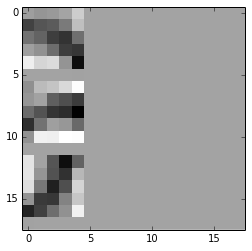

In [37]:
weights = W0.get_value()

#weights = weights.swapaxes(0,1)
weights = weights.swapaxes(1,3)
weights = weights.swapaxes(1,2)
print weights.shape

def getImageMat(weights):
    cols = 3
    rows = 3
    xwidth = weights.shape[1]+1
    ywidth = weights.shape[2]+1
    print xwidth
    print ywidth
    channels = 3
    vis = numpy.zeros((rows*xwidth,cols*ywidth,channels),dtype=numpy.float32)
    print vis.shape
    for i in range(0,weights.shape[0]):
        startx = ((i%rows)*xwidth)
        endx = startx + weights.shape[1]
        starty = (i/rows*ywidth)
        endy = starty+weights.shape[2]
        minval = (np.min(weights[i,:,:]))
        maxval = (np.max(weights[i,:,:]))
        vis[startx:endx, starty:endy, :] = weights[i,:,:]#((weights[i,:,:])-minval)/(maxval-minval) ANDERS ALS SONST!!!!s
    return vis

imgMat = getImageMat(weights)[:,:]
minV = (np.min(imgMat[:,:]))
maxV = (np.max(imgMat[:,:]))
plt.imshow(((imgMat[:,:])-minV)/(maxV-minV),interpolation='none',cmap="seismic")
plt.show()